## SPAM detection - MKD

Importing libraries:

In [2]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

Read dataset and mount google drive:

In [5]:
data = pd.read_csv("/content/drive/MyDrive/Spam_detection/spam2.csv",encoding = "'latin'")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
data["text"] = data.v2
data["spam"] = data.v1

## 1. Splitting data

In [62]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2)  # 80-20

In [9]:
data.info

<bound method DataFrame.info of         v1  ...  spam
0      ham  ...   ham
1      ham  ...   ham
2     spam  ...  spam
3      ham  ...   ham
4      ham  ...   ham
...    ...  ...   ...
5567  spam  ...  spam
5568   ham  ...   ham
5569   ham  ...   ham
5570   ham  ...   ham
5571   ham  ...   ham

[5572 rows x 7 columns]>

In [10]:
emails_train.shape

(4457,)

## 2. Preprocessing

Python functions for cleaning text:

In [63]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

# x_train[0]

Load LabelEncoder and fit/transform the data:

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [13]:
train_y

array([0, 0, 0, ..., 0, 0, 0])

## 3. Tokenize

In [14]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

## 4. Padding

In [16]:
from keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([   0,    0,    0, ..., 3496,    3,  104], dtype=int32)

## 5. Model

Load models:

In [17]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [18]:
# create the model
import tensorflow as tf
embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=10, validation_data=(x_test_features, test_y))

Epoch 1/10
9/9 [==============================] - 184s 21s/step - loss: 0.3043 - accuracy: 0.8649 - val_loss: 0.2385 - val_accuracy: 0.8717
Epoch 2/10
9/9 [==============================] - 182s 21s/step - loss: 0.1837 - accuracy: 0.9307 - val_loss: 0.1763 - val_accuracy: 0.9408
Epoch 3/10
9/9 [==============================] - 180s 20s/step - loss: 0.1048 - accuracy: 0.9762 - val_loss: 0.1160 - val_accuracy: 0.9641
Epoch 4/10
9/9 [==============================] - 179s 20s/step - loss: 0.0630 - accuracy: 0.9868 - val_loss: 0.0887 - val_accuracy: 0.9749
Epoch 5/10
9/9 [==============================] - 183s 20s/step - loss: 0.0449 - accuracy: 0.9897 - val_loss: 0.0687 - val_accuracy: 0.9794
Epoch 6/10
9/9 [==============================] - 175s 20s/step - loss: 0.0321 - accuracy: 0.9924 - val_loss: 0.0603 - val_accuracy: 0.9812
Epoch 7/10
9/9 [==============================] - 164s 18s/step - loss: 0.0221 - accuracy: 0.9948 - val_loss: 0.0587 - val_accuracy: 0.9830
Epoch 8/10
9/9 [====

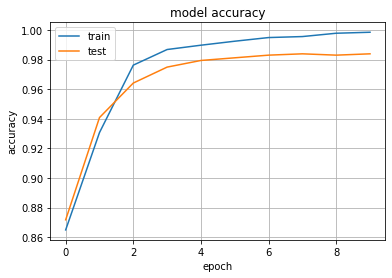

In [21]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()


In [25]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [ ]:
y_predict

In [26]:
cf_matrix =confusion_matrix(test_y,y_predict)

Confusion matrix:

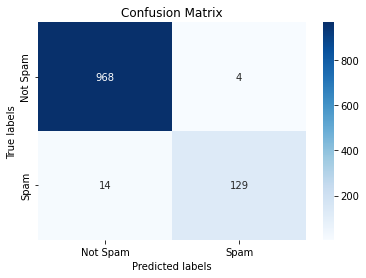

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

Metrics (Precision, Recall, F1 score):

In [22]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [28]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [29]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 96.99%
Recall: 90.21%
F1 Score: 93.48%


In [64]:
np.round(f1_score(test_y,y_predict), 3)

0.935

## 6. Predict Macedonian mail

Install Google API translator with pip and load MKD language:

In [ ]:
!pip install googletrans

In [ ]:
!pip uninstall googletrans
!pip install googletrans==3.1.0a0

In [33]:
from googletrans import Translator, constants
from pprint import pprint

# init the Google API translator
translator = Translator()

In [ ]:
# print all available languages
print("Total supported languages:", len(constants.LANGUAGES))
print("Languages:")
pprint(constants.LANGUAGES)  # Long list 

Test on Macedonian mail:

In [48]:
mk_mail = "Не, мислам дека не оди кај нас, сепак живее овде"

translation = translator.translate(mk_mail, src="mk")
print(f"{translation.origin} ({translation.src}) --> {translation.text} ({translation.dest})")

Не, мислам дека не оди кај нас, сепак живее овде (mk) --> No, I don't think he goes to us, he still lives here (en)


In [49]:
text_mkd = [translation.text]
text_mkd

["No, I don't think he goes to us, he still lives here"]

In [51]:
ynew = model.predict(np.array(tokenizer.texts_to_sequences(text_mkd)))  # 0 или 1

In [58]:
text = "Spam" if np.round(ynew[0][0]) == 1 else "Not spam"

In [69]:
print(f"My sample mail was:\n\n-----------{text}-----------")

My sample mail was:

-----------Not spam-----------
